# Lab 1 : First order methods on regression models

#### Authors: A. Gramfort, R. Gower, P. Ablin, M. Massias, Q. Bertrand, N. Gazagnadou

## Aim

The aim of this material is to code 
- proximal gradient descent (PGD)
- accelerated proximal gradient descent (APGD) 

for 
- linear regression
- logistic regression 

models.

The proximal operators we will use are the 
- L2 penalization
- L1 penalization

## VERY IMPORTANT

- This work **must be done by pairs of students**.
- **Each** student must send their work **before the 6th of october at 21:59**, using the **moodle platform**.
- This means that **each student in the pair sends the same file**
- On the moodle, in the "Optimization for Data Science" course, you have a "devoir" section called **Rendu TP du 30 septembre 2019**. This is where you submit your jupyter notebook file. 
- The **name of the file must be** constructed as in the next cell

# Gentle reminder: no evaluation if you don't respect this EXACTLY

### How to construct the name of your file

In [0]:
# Change here using YOUR first and last names
fn1 = "romain"
ln1 = "avouac"
fn2 = "alhousseynou"
ln2 = "ball"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["lab1", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

lab1_avouac_romain_and_ball_alhousseynou.ipynb


In [0]:
## to embed figures in the notebook
%matplotlib inline

## Part 0 : Introduction

We'll start by generating sparse vectors and simulating data

### Generating sparse coefficients

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm
np.set_printoptions(precision=2)  # to have simpler print outputs with numpy

Text(0.5, 1.0, 'Parameters / Coefficients')

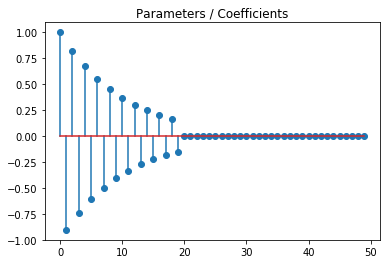

In [0]:
n_features = 50
n_samples = 1000
idx = np.arange(n_features)
coefs = ((-1) ** idx) * np.exp(-idx / 10.)
coefs[20:] = 0.
plt.stem(coefs)
plt.title("Parameters / Coefficients")

### Functions for the simulation of the models

In [0]:
from numpy.random import multivariate_normal
from scipy.linalg.special_matrices import toeplitz
from numpy.random import randn


def simu_linreg(coefs, n_samples=1000, corr=0.5):
    """Simulation of a linear regression model
    
    Parameters
    ----------
    coefs : `numpy.array`, shape (n_features,)
        Coefficients of the model
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
        Correlation of the features

    Returns
    -------
    A : `numpy.ndarray`, shape (n_samples, n_features)
        Simulated features matrix. It samples of a centered Gaussian 
        vector with covariance given by the Toeplitz matrix
    
    b : `numpy.array`, shape (n_samples,)
        Simulated labels
    """
    # Construction of a covariance matrix
    cov = toeplitz(corr ** np.arange(0, n_features))
    # Simulation of features
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    # Simulation of the labels
    b = A.dot(coefs) + randn(n_samples)
    b = b.reshape((n_samples, 1)) # reshape b to enable matrix multiplication
    return A, b

def sigmoid(t):
    """Sigmoid function"""
    return 1. / (1. + np.exp(-t))

def simu_logreg(coefs, n_samples=1000, corr=0.5):
    """Simulation of a logistic regression model
    
    Parameters
    ----------
    coefs : `numpy.array`, shape (n_features,)
        Coefficients of the model
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
        Correlation of the features

    Returns
    -------
    A : `numpy.ndarray`, shape (n_samples, n_features)
        Simulated features matrix. It samples of a centered Gaussian 
        vector with covariance given by the Toeplitz matrix
    
    b : `numpy.array`, shape (n_samples,)
        Simulated labels
    """
    cov = toeplitz(corr ** np.arange(0, n_features))
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    p = sigmoid(A.dot(coefs))
    b = np.random.binomial(1, p, size=n_samples)
    b = 2 * b - 1
    b = b.reshape((n_samples, 1)) # reshape b to enable matrix multiplication
    return A, b

## Generate the data

In [0]:
A, b = simu_linreg(coefs)
# A, b = simu_logreg(coefs)  # uncomment when you want to test logistic regression

## Part 1 : Proximal operators

We remind that the proximal operator of a function $R$ is given by:

$$
\text{prox}_{\lambda\,R}(x) = \arg\min_z \left\{ \frac{1}{2} \Vert x - z\Vert_2^2 + \lambda \,R(z) \right\}.
$$


We have in mind to use the following cases

- L2 penalization: $\lambda\, R(z) = \frac{\lambda}{2} \|z\|_2^2$
- L1 penalization: $\lambda\, R(z) = \lambda\|z|\|_1$

where $\lambda \geq 0$ is a regularization parameter.

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Code a function that computes $\lambda \, R(x)$ in both cases and $\text{prox}_{\lambda\, R}(x)$ for L2 and  L1 penalization (use the slides of the first course to get the formulas), using the prototypes given below</li>
     <li>Hint: for the prox of the L1 norm you can either use the formula from the course or rewrite it with np.max and np.sign functions
    </li>
      <li>Visualize the identity function and the proximity operators of the L2 and L1 on the real axis
    </li>
    </ul>
</div>

In [0]:
def prox_L1(x, lmbd):
    """Proximal operator for the L1 at x"""
    z = np.sign(x) * np.maximum(np.abs(x) - lmbd, 0)
    return z

def L1_norm(x, lmbd):
    """Value of the L1 penalization at x"""
    return lmbd*norm(x, 1)

def prox_L2(x, lmbd):
    """Proximal operator for the L2 at x"""
    z = x / (1+2*lmbd)
    return z

def L2_norm(x, lmbd):
    """Value of the L2 penalization at x"""
    return (lmbd/2)*norm(x, 2)

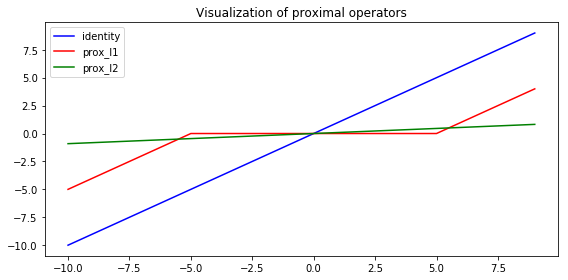

In [0]:
# Plots TODO
lambda_test = 5
x_range = np.array(range(-10, 10, 1))
y_prox_l1 = np.array([prox_L1(x, lambda_test) for x in x_range])
y_prox_l2 = np.array([prox_L2(x, lambda_test) for x in x_range])
y_identity = x_range

fig, plt_compar_prox = plt.subplots(1, 1, figsize=(8, 4))
plt_compar_prox.plot(x_range, y_identity, color='blue', label='identity')
plt_compar_prox.plot(x_range, y_prox_l1, color='red', label='prox_l1')
plt_compar_prox.plot(x_range, y_prox_l2, color='green', label='prox_l2')
plt_compar_prox.set_title('Visualization of proximal operators', size=12)
plt_compar_prox.legend()
plt.tight_layout()

## Visualization

We are now going to visualize the effect of the proximity operators on coefficients.

(-2, 2)

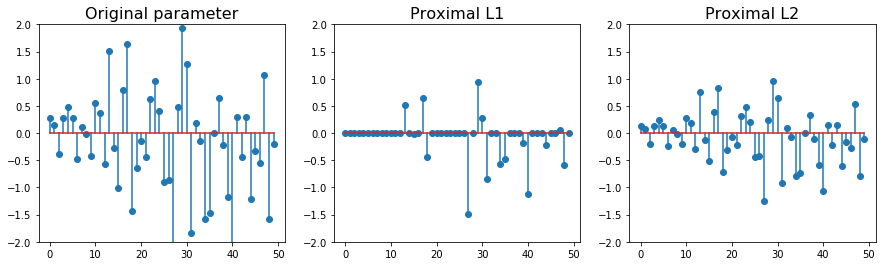

In [0]:
x = randn(50)
l_l1 = 1.
l_l2 = 0.5

plt.figure(figsize=(15.0, 4.0))
plt.subplot(1, 3, 1)
plt.stem(x)
plt.title("Original parameter", fontsize=16)
plt.ylim([-2, 2])
plt.subplot(1, 3, 2)
plt.stem(prox_L1(x, lmbd=l_l1))
plt.title("Proximal L1", fontsize=16)
plt.ylim([-2, 2])
plt.subplot(1, 3, 3)
plt.stem(prox_L2(x, lmbd=l_l2))
plt.title("Proximal L2", fontsize=16)
plt.ylim([-2, 2])

<div class="alert alert-success">
    <b>Question</b>:
     <ul>
      <li>Comment what you observe (1 or 2 sentences).</li>
    </ul>
</div>

Due to soft-tresholding, using the L1 norm penalization sets most coefficients to zero, except the ones that were initially the highest. The L2 norm penalization only reduces the weights, but don't cancel them altogether. For both norms, the effect increases as the penalization level rises, controlled by the value of lambda.

## Part 2: Gradients

The problems we want to minimize take the form:
$$
\arg\min_x f(x) + \lambda \,R(x)
$$
where $f$ is $L$-smooth and $R$ is prox friendly.

Consider the following cases:

**Linear regression**, where 
$$
f(x) = \frac{1}{2n} \sum_{i=1}^n (b_i - a_i^\top x)^2 = \frac{1}{2 n} \| b - A x \|_2^2,
$$
where $n$ is the sample size, $b = [b_1 \cdots b_n]$ is the vector of labels and $A^\top = [a_1,\ldots, a_n] \in \mathbb{R}^{d \times n}$ is the matrix of features.

**Logistic regression**, where
$$
f(x) = \frac{1}{n} \sum_{i=1}^n \log(1 + \exp(-b_i a_i^\top x)),
$$
where $n$ is the sample size, and where labels $b_i \in \{ -1, 1 \}$ for all $i$.

We need to be able to compute $f$ and its gradient $\nabla f$

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Compute on paper the gradient $\nabla f$ of $f$ for both cases (linear and logistic regression)</li>
      <li>Code a function that computes $f$ and its gradient $\nabla f$ in both cases, using the prototypes below.</li>
      <li>Check that these loss functions are correct by numerically checking their ouputs</li>
      <li>Check that these functions are correct by numerically checking the gradient, using the function ``<a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.check_grad.html">check_grad</a>`` from ``scipy.optimize``. Remark: use the functions `simu_linreg` and `simu_logreg` to simulate data according to the right model</li>
    </ul>
</div>

In [0]:
def loss_linreg(x, A, b):
    """Least squares loss"""
    x_vec = np.reshape(x, (n_features, 1))
    loss = 1/(2*n_samples) * norm(b - A@x_vec, 2)**2
    return loss

def grad_linreg(x, A, b):
    """Least squares gradient"""
    x_vec = np.reshape(x, (n_features, 1))
    grad = (-1/n_samples) * A.T @ (b - A@x_vec)
    grad = grad.flatten()
    return grad

def loss_logreg(x, A, b):
    """Logistic loss"""
    x_vec = np.reshape(x, (n_features, 1))
    loss = (1/n_samples) * np.sum(np.log(1 + np.exp(-b * A@x_vec)))
    return loss

def grad_logreg(x, A, b):
    """Logistic gradient"""
    x_vec = np.reshape(x, (n_features, 1))
    vec_terms_sum = np.array([b[i]*np.exp(-b[i] * A[i]@x_vec) / (1 + np.exp(-b[i] * A[i]@x_vec)) * A[i] for i in range(n_samples)])
    grad = -(1/n_samples) * np.sum(vec_terms_sum, 0)
    # grad = grad.flatten()
    return grad

# TO BE COMPLETED

In [0]:
# Check that the losses are not wrong by computing them in zero
x_zeros = np.zeros(50)
x_zeros = np.reshape(x_zeros, (n_features, 1))
assert(np.isclose(loss_linreg(x_zeros, A, b), 1/(2*n_samples) * np.sum(b**2)))
assert(np.isclose(loss_logreg(x_zeros, A, b), np.log(2)))

In [0]:
# Check that the gradients are correct using a random vector
from scipy.optimize import check_grad, approx_fprime
x_test = randn(n_features)

# For linear regression
print(check_grad(loss_linreg, grad_linreg, x_test, A, b))

# For logistic regression
A_log_check, b_log_check = simu_logreg(coefs) 
b_log_check = b_log_check.reshape((n_samples, 1))
print(check_grad(loss_logreg, grad_logreg, x_test, A_log_check, b_log_check))

2.448924041497985e-06
2.2135777456363877e-07


The output values of the check_grad are very small, which indicate that our gradient functions give very close results to finite-difference approximations computed numerically. We can thus be confident that our gradient functions correctly compute gradients of our loss functions.

## Part 3: Solvers

We know have a function to compute $f$, $\nabla f$ and $R$ and $\text{prox}_{\lambda R}$. 

We want now to code the PGD and APGD solvers to minimize

$$
\arg\min_x f(x) + \lambda \, R(x)
$$

where $\lambda >0$ is the regularization parameter

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Compute on paper the Lipschitz constant for linear and logistic regression losses. Remark: for the logistic regression, you should try to upper bound the second derivative</li>
      <li>Hint: the computation of the Lipschitz constant for the linear regression should be easy (cf course).
         But the computation of the Lipschitz constant for the logistic regression may be trickier. 
                 You may want to write $f$ as $f(x) = \frac{1}{n} \sum_i \phi(b_i a_i^\top x)$, and then show that $|\phi''| \leq \frac{1}{4}$.</li>
      <li>Implement functions that compute the Lipschitz constant for both cases (linear and logistic regression). Note that the operator norm of a matrix can 
  be computed using the function <a href="https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.norm.html">numpy.linalg.norm</a> (Be careful with the norm you chose! Read the documentation
  of the function)</li>
      <li>Finish the functions `PGD` and `APGD` below that implements the 
  PGD (Proximal Gradient Descent) and APGD (Accelerated Proximal 
  Gradient Descent) algorithms.
       Note: PGD is sometimes called ISTA (Iterative Soft Thresholding Algorithm) and APGD is sometimes called FISTA (Fast ISTA)</li> 
    </ul>
</div>

### Computation of Lipschitz constants for linear and logistic regression losses

We know that the linear regression loss is $\frac{\sigma_{max}(A)^2}{n}$-smooth, where $\sigma_{max}(A)$ is the highest singular value of A.

For logistic regression, we have $f(x)=\frac{1}{n}\sum_{i=1}^n\phi(b_i a_i^T x)$ with $\phi=\log \circ \: (1+\exp)$. 

Since $\forall x, x(1-x) \leq \frac{1}{4}$, we have $\forall y, \phi''(y)=\phi'(y)(1-\phi'(y)) \leq \frac{1}{4}$.

So we have : $\nabla^²f(x)=\frac{1}{n}\sum_{i=1}^n\phi''(-b_i a_i^T x) a_i^T a_i \leq \frac{1}{4n} \sum_{i=1}^na_i^T a_i = \frac{1}{4n} A^T A$.

Thus finally : $\forall d, d^T \nabla^²f(x) d \leq \frac{1}{4n} d^T A^T A D = \frac{1}{4n} \parallel Ad \parallel^2_2$ and since by property : $\parallel Ad \parallel^2_2 \leq \sigma_{max}(A)² \parallel d \parallel^2_2$, we conclude that the logistic regression loss is $\frac{\sigma_{max}(A)^2}{4n}$-smooth.

In [0]:
# TO BE COMPLETED
from numpy.linalg import svd

# Calculate the smoothness constant for least squares loss
def smoothness_const_linreg(A):
    """Lipschitz constant for least squares loss""" 
    max_sing_val = svd(A, compute_uv=False)[0] # Compute max singular value of A via SVD decomposition
    smooth_const = max_sing_val**2 / n_samples
    return smooth_const

# Calculate the smoothness constant for logistic loss    
def smoothness_const_logreg(A):
    """Lipschitz constant for logistic loss"""    
    max_sing_val = svd(A, compute_uv=False)[0] # Compute max singular value of A via SVD decomposition
    smooth_const = max_sing_val**2 / (4*n_samples)
    return smooth_const

# Compute smoothness constants
smooth_linreg = smoothness_const_linreg(A)
smooth_logreg = smoothness_const_logreg(A)

In [0]:
def PGD(x0, A, b, f, grad_f, R, prox_R, step, lmbd=0., n_iter=50,
         x_true=coefs, verbose=True):
    """Proximal gradient descent algorithm"""
    x = x0.copy()
    n_samples, n_features = A.shape

    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = norm(x - x_true) / norm(x_true)
    errors.append(err)
    # Current objective
    obj = f(x, A, b) + R(x, lmbd)
    objectives.append(obj)
    if verbose:
        print("Lauching PGD solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
    for k in range(n_iter + 1):

        #### TODO ####
        x = prox_R(x - step*grad_f(x, A, b), lmbd*step)
        obj = f(x, A, b) + R(x, lmbd)
        err = norm(x - x_true) / norm(x_true)
        errors.append(err)
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                              ("%.2e" % err).rjust(8)]))
    return x, np.array(objectives), np.array(errors)

In [0]:
# TO BE COMPLETED

def APGD(x0, A, b, f, grad_f, R, prox_R, step, lmbd=0., n_iter=50,
         x_true=coefs, verbose=True):
    """Accelerated Proximal gradient descent algorithm"""
    x = x0.copy()
    x_new = x0.copy()
    # An extra variable is required for APGD
    z = x0.copy()
    n_samples, n_features = A.shape
    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = norm(x - x_true) / norm(x_true)
    errors.append(err)
    # Current objective
    obj = f(x, A, b) + R(x, lmbd)
    objectives.append(obj)
    t = 1.
    t_new = 1.    
    if verbose:
        print("Lauching APGD solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
    for k in range(n_iter + 1):

        #### TODO ####
        x_new = prox_R(z - step*grad_f(z, A, b), lmbd*step)
        t_new = (1 + np.sqrt(1 + 4*t**2)) / 2
        z_new = x_new + (t-1) / t_new * (x_new - x)
        x, t, z = x_new, t_new, z_new
        obj = f(x, A, b) + R(x, lmbd)
        err = norm(x - x_true) / norm(x_true)
        errors.append(err)
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                              ("%.2e" % err).rjust(8)]))
    return x, np.array(objectives), np.array(errors)

## Algorithms comparison and numerical experiments

In [0]:
# Some definitions before launching the algorithms
x0 = np.zeros(n_features)
n_iter = 1000
lmbd = 1e-2

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Compute a precise minimum and a precise minimizer of the problem (linear regression or logistic regression) using the parameters given above. This can be done by using APGD with 1000 iterations and setting `x_true` to `coeffs`.</li>
    <li>Compare the convergences of PGD and APGD, in terms of distance to the minimum and 
  distance to the minimizer you have computed. Do your plots using a logarithmic scale of the y-axis.</li>
    </ul>
</div>

### Computation of a precise minimum/minimizer using FISTA (LASSO regression)

In [0]:
x_minimizer_fista, vec_obj_fista, vec_err_fista = APGD(x0, A=A, b=b,
    f=loss_linreg, grad_f=grad_linreg, 
    R=L1_norm, prox_R=prox_L1, step=1/smooth_linreg, 
    lmbd=lmbd, n_iter=n_iter, x_true=coefs, verbose=False)

min_fista = loss_linreg(x_minimizer_fista, A, b) + L1_norm(x_minimizer_fista, lmbd=lmbd)
print('FISTA minimizer : x*=' + str(x_minimizer_fista))
print('Value of the objective function in the FISTA minimizer : f(x*) + lambda*R(x*) = ' + str(min_fista))
print('Final estimation error : ' + str(vec_err_fista[-1]))

FISTA minimizer : x*=[ 1.09e+00 -9.54e-01  8.50e-01 -7.22e-01  6.78e-01 -7.03e-01  5.25e-01
 -3.78e-01  3.53e-01 -3.79e-01  2.90e-01 -2.41e-01  2.79e-01 -3.25e-01
  2.66e-01 -2.22e-01  1.74e-01 -1.57e-01  1.61e-01 -1.17e-01 -7.20e-03
  1.85e-02 -0.00e+00  0.00e+00 -0.00e+00 -0.00e+00 -0.00e+00 -0.00e+00
  8.29e-04 -0.00e+00 -5.72e-03  2.33e-02 -0.00e+00 -0.00e+00  0.00e+00
  1.65e-02 -0.00e+00  0.00e+00  0.00e+00  3.22e-02 -7.00e-02  8.69e-02
  0.00e+00  9.51e-03  1.94e-02 -0.00e+00 -3.39e-02 -2.63e-02 -9.23e-03
  0.00e+00]
Value of the objective function in the FISTA minimizer : f(x*) + lambda*R(x*) = 0.5815280243869188
Final estimation error : 0.12373916264317077


### Comparison of PGD and APGD rates of convergence

We compute and plot for each algorithm and each iteration : $\frac{f(x^t)-f(x^*)}{\parallel x^1 - x^* \parallel^2_2}$

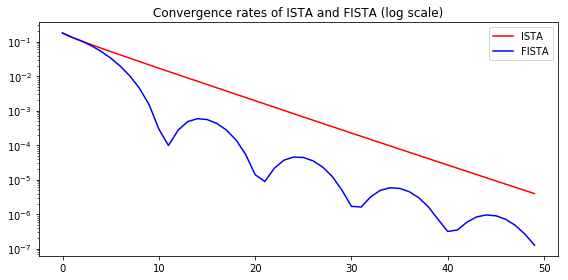

In [0]:
# Compute ISTA solution
x_minimizer_ista, vec_obj_ista, vec_err_ista = PGD(x0=x0, A=A, b=b,
    f=loss_linreg, grad_f=grad_linreg, 
    R=L1_norm, prox_R=prox_L1, step=1/smooth_linreg, 
    lmbd=lmbd, n_iter=n_iter, x_true=coefs, verbose=False)

min_ista = loss_linreg(x_minimizer_ista, A, b) + L1_norm(x_minimizer_ista, lmbd=lmbd)

# Compute distance between objective and minimum at each period, normalized by the distance
# between the initialization vector and the final minimizer
vec_dist_norm_ista = (vec_obj_ista - min_ista) / norm(x0 - x_minimizer_ista, 2)**2
vec_dist_norm_fista = (vec_obj_fista - min_fista) / norm(x0 - x_minimizer_fista, 2)**2

fig, plt_convergence = plt.subplots(1, 1, figsize=(8, 4))
plt_convergence.plot(vec_dist_norm_ista[:50], color='red', label='ISTA')
plt_convergence.plot(vec_dist_norm_fista[:50], color='blue', label='FISTA')
plt.yscale('log')
plt_convergence.set_title('Convergence rates of ISTA and FISTA (log scale)', size=12)
plt_convergence.legend()
plt.tight_layout()

The PGD curve appears linear, which suggest a convergence at log speed. As expected, the APGD reaches a satisfactory solution (tolerance < 0.001) much quicker : it requires only about 10 iterations, whereas the PGD requires about 30 iterations to get to the same tolerance level.

<div class="alert alert-success">
    <b>EXERCISE</b>:
     <ul>
      <li>Compare the solution you obtain with ista and fista with the true parameter `coefs` of
  the model. This can be done with `plt.stem` plots.</li>
    <li>In linear regression and logistic regression, study the influence of the correlation 
  of the features on the performance of the optimization algorithms. Explain.</li>
    <li>In linear regression and logistic regression, study the influence of the level of L2 
  penalization on the performance of the optimization algorithms. Explain.</li>
    <li>In linear regression and logistic regression, compare the performance of the optimization
  algorithms for L2 and L1 penalizations. Explain</li>
    </ul>
</div>

### Comparison of ISTA/FISTA estimated coefficients and true coefficients

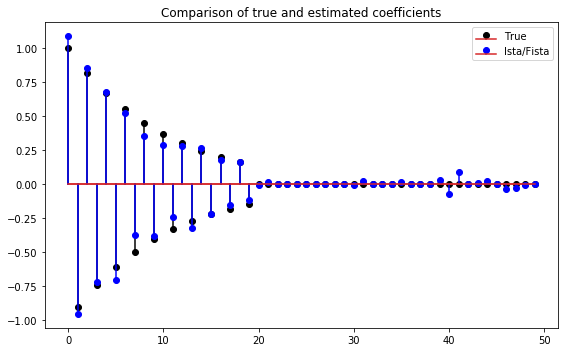

In [0]:
# Ista and Fista solutions are identical so we plot only one solution
fig, plt_coefs = plt.subplots(1, 1, figsize=(8, 5))
plt_coefs.stem(coefs, linefmt='k', markerfmt='ko', label='True')
plt_coefs.stem(x_minimizer_ista, linefmt='-b',markerfmt='bo', label='Ista/Fista')
plt_coefs.set_title('Comparison of true and estimated coefficients', size=12)
plt_coefs.legend()
plt.tight_layout()

If we set the number of iterations sufficiently high, ISTA and FISTA both reach the same solution. This solution appears very close to the true coefficients distribution, which corroborates the low error rates we get after convergence of both algorithms.

### Influence of features correlation on the performance of the optimization algorithms

In [0]:
corr_levels = np.array(range(11)) / 10

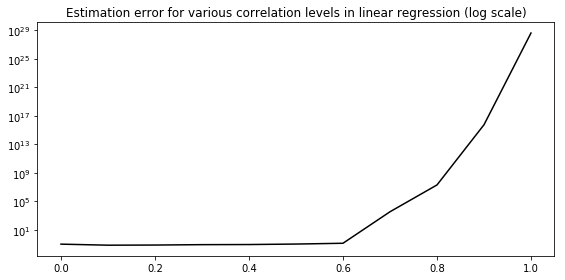

In [0]:
# Simulate linear regression for various correlation levels
linregs_corr = [simu_linreg(coefs, n_samples=1000, corr=c) for c in corr_levels]

# Perform APGD for each simulated data, store final error levels
apgd_errors_corr_lin = [APGD(x0=x0, A=linregs_corr[i][0], b=linregs_corr[i][1],
    f=loss_linreg, grad_f=grad_linreg, 
    R=L1_norm, prox_R=prox_L1, step=1/smooth_linreg, 
    lmbd=lmbd, n_iter=20, x_true=coefs, verbose=False)[2][-1]
              for i in range(len(linregs_corr))]

# Plot error levels against correlation levels
fig, plt_correlations_lin = plt.subplots(1, 1, figsize=(8, 4))
plt_correlations_lin.plot(corr_levels, apgd_errors_corr_lin, color='black')
plt.yscale('log')
plt_correlations_lin.set_title('Estimation error for various correlation levels in linear regression (log scale)', size=12)
plt.tight_layout()

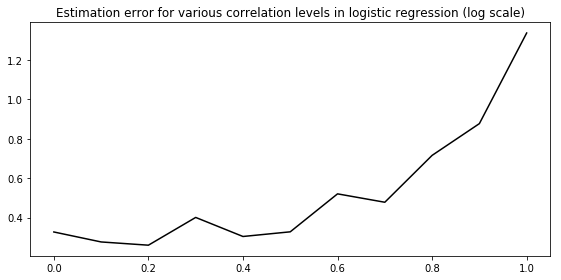

In [0]:
# Simulate logistic regression for various correlation levels
logregs_corr = [simu_logreg(coefs, n_samples=1000, corr=c) for c in corr_levels]

# Perform APGD for each simulated data, store final error levels
apgd_errors_corr_log = [APGD(x0=x0, A=logregs_corr[i][0], b=logregs_corr[i][1],
    f=loss_logreg, grad_f=grad_logreg, 
    R=L1_norm, prox_R=prox_L1, step=1/smooth_logreg, 
    lmbd=lmbd, n_iter=20, x_true=coefs, verbose=False)[2][-1]
              for i in range(len(logregs_corr))]

# Plot error levels against correlation levels
fig, plt_correlations_log = plt.subplots(1, 1, figsize=(8, 4))
plt_correlations_log.plot(corr_levels, apgd_errors_corr_log, color='black')
plt_correlations_log.set_title('Estimation error for various correlation levels in logistic regression (log scale)', size=12)
plt.tight_layout()

In both linear and logistic regressions, the estimation error we get after convergence goes up as the correlation between features increases. This problem seems particularly important for LASSO, as levels of correlation above 0.6 appear to generate erratic behavior, as indicated by the error rate which goes much higher than one. In logistic regression, the relation appears much more continuous. 

The rationale for this observed relationship might be that the presence of multicolinearity (i.e. high levels of correlations between multiple features) reduces the available statistical information in the data, as very few features are needed to summarize this information. As a result, it is harder for the training algorithm to reach a satisfactory solution, similarly to a case in which we would reduce the sample size.

### Influence of L2-penalization levels on the performance of the optimization algorithms

In [0]:
lambda_range = np.array([1E-6, 1E-5, 1E-4, 1E-3, 1E-2, 1E-1, 1, 10, 100])

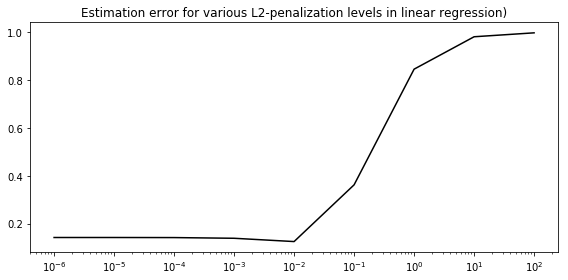

In [0]:
# Linear regression

# Store final error levels for each value of lambda
apgd_errors_penal_lin = [APGD(x0=x0, A=A, b=b,
    f=loss_linreg, grad_f=grad_linreg, 
    R=L2_norm, prox_R=prox_L2, step=1/smooth_linreg, 
    lmbd=l, n_iter=20, x_true=coefs, verbose=False)[2][-1]
              for l in lambda_range]

lambda_min_linreg = lambda_range[np.argmin(apgd_errors_penal_lin)]

# Plot error levels against correlation levels
fig, plt_l2penal_lin = plt.subplots(1, 1, figsize=(8, 4))
plt_l2penal_lin.plot(lambda_range, apgd_errors_penal_lin, color='black')
plt.xscale('log')
plt_l2penal_lin.set_title('Estimation error for various L2-penalization levels in linear regression)', size=12)
plt.tight_layout()

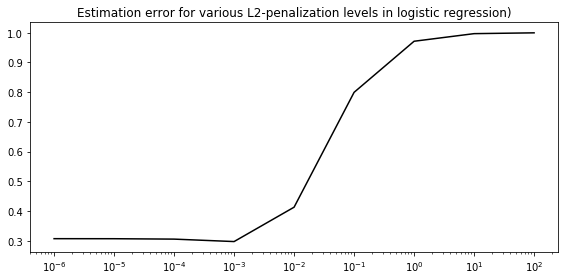

In [0]:
# Simulate logistic regression
A_log, b_log = simu_logreg(coefs)

# Store final error levels for each value of lambda
apgd_errors_penal_log = [APGD(x0=x0, A=A_log, b=b_log,
    f=loss_logreg, grad_f=grad_logreg, 
    R=L2_norm, prox_R=prox_L2, step=1/smooth_logreg, 
    lmbd=l, n_iter=20, x_true=coefs, verbose=False)[2][-1]
              for l in lambda_range]

lambda_min_logreg = lambda_range[np.argmin(apgd_errors_penal_log)]

# Plot error levels against correlation levels
fig, plt_l2penal_log = plt.subplots(1, 1, figsize=(8, 4))
plt_l2penal_log.plot(lambda_range, apgd_errors_penal_log, color='black')
plt.xscale('log')
plt_l2penal_log.set_title('Estimation error for various L2-penalization levels in logistic regression)', size=12)
plt.tight_layout()

For a given correlation level between features of 0.5, we find that the level of L2-penalization that minimizes the error rate is equal to 1E-6, both for linear and logistic regresssion. However, in both cases, the error rates remain very close for values of lambda inferior or equal to 1E-2. These results suggest that (very) small levels of L2-penalization are preferable for an optimal estimation of the coefficients. The reason for that might be that higher values of the peanlization tend to overreduce the weights as compared to the ground truth. However, we might get different optimal penalization levels for different correlation levels between features in the dataset.

### Influence of the penalization type on the performance of the optimization algorithms

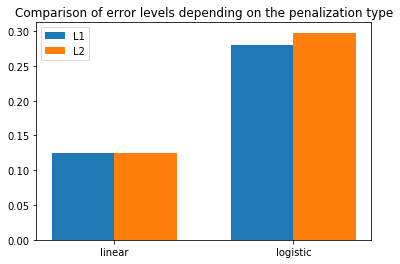

In [0]:
error_linreg_l1 = APGD(x0=x0, A=A, b=b,
    f=loss_linreg, grad_f=grad_linreg, 
    R=L1_norm, prox_R=prox_L1, step=1/smooth_linreg, 
    lmbd=lambda_min_linreg, n_iter=20, x_true=coefs, verbose=False)[2][-1]

error_linreg_l2 = APGD(x0=x0, A=A, b=b,
    f=loss_linreg, grad_f=grad_linreg, 
    R=L2_norm, prox_R=prox_L2, step=1/smooth_linreg, 
    lmbd=lambda_min_linreg, n_iter=20, x_true=coefs, verbose=False)[2][-1]

error_logreg_l1 = APGD(x0=x0, A=A_log, b=b_log,
    f=loss_logreg, grad_f=grad_logreg, 
    R=L1_norm, prox_R=prox_L1, step=1/smooth_logreg, 
    lmbd=lambda_min_logreg, n_iter=20, x_true=coefs, verbose=False)[2][-1]

error_logreg_l2 = APGD(x0=x0, A=A_log, b=b_log,
    f=loss_logreg, grad_f=grad_logreg, 
    R=L2_norm, prox_R=prox_L2, step=1/smooth_logreg, 
    lmbd=lambda_min_logreg, n_iter=20, x_true=coefs, verbose=False)[2][-1]

reg_types = ['linear', 'logistic']
l1_errors = [error_linreg_l1, error_logreg_l1]
l2_errors = [error_linreg_l2, error_logreg_l2]

x = np.arange(len(reg_types))
width = 0.35 

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, l1_errors, width, label='L1')
rects2 = ax.bar(x + width/2, l2_errors, width, label='L2')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title('Comparison of error levels depending on the penalization type')
ax.set_xticks(x)
ax.set_xticklabels(reg_types)
ax.legend()

For both linear and logistic regressions, the L1-penalization slightly outperforms the L2-penalization. The reason for that is very likely that the distribution of the true coefficients is very sparse (a lot of the coefficients have been set to 0). As a result, the L1-penalization exhibits better performance as its effect is precisely to set some weights to 0 due to the fact that it is based on soft-thresholding of the coefficients.